# TP4: Decision trees & random forests
The aim of this tutorial is to get familiar with the use of decision trees and their generalizations on simple examples using `scikit-learn` tools.

## Completing your installation first
You will need to install packages `python-graphviz` first. If needed, uncomment the `conda` command below:

In [2]:
# If needed, uncomment the line below:
# install python-graphviz

In [5]:
# # Add graphviz to path
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin'

In [105]:
from pylab import *
import matplotlib.pyplot as plt

# Load the library with the iris dataset
from sklearn.datasets import load_iris, load_wine

# Load scikit's decision tree classifier
from sklearn import tree

# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# Load scikit's Linear Regression library
from sklearn.linear_model import LinearRegression

# To visualize trees
import graphviz 

# Load pandas to manipulate data frames (Excel like)
import pandas as pd

# Load numpy
import numpy as np

# Set random seed
np.random.seed(0)

# Load seaborn
import seaborn as sns

The data for this tutorial is famous. Called, **the iris dataset**, it contains four variables measuring various parts of iris flowers of three related species, and then a fourth variable with the species name. The reason it is so famous in machine learning and statistics communities is because the data requires very little preprocessing (i.e. no missing values, all features are floating numbers, etc.).

In [7]:
iris = load_iris()

## Step 1: explore the data set
1. What is the structure of the object `iris` ?

2. Plot this dataset in a well chosen set of representations to explore the data.

---

1. This data sets consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray. The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.  
It contains 2 arrays : one with the numerical data, the other with the targets data.  
It also contains the features name and target name.  
Finally it has a description of the dataset : author, date and a short description of the data.

---

2.

In [8]:
from sklearn import preprocessing

Let's scale the data (mean = 0 and standard variation = 1).

In [9]:
iris_scaled = preprocessing.scale(iris.data)

Let's compute the covariance matrix of the scaled data to see how the features are correlated.

In [10]:
cov_iris = np.cov(iris_scaled.T)

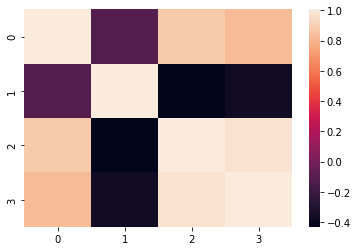

In [11]:
sns.heatmap(cov_iris)
plt.show()

This heatmap shows several things at first glance:  
- The petal features are strongly correlated (width and length); these attributes could be the two first principal components used in PCA;
- The sepal width is not correlated at all with the rest of the features; as such, it will be virtually useless to classify the species;
- The sepal length is somewhat correlated with the petal features but to a lesser extent.

Let's us showcase these first results: 

In [12]:
iris0 = iris.data[iris.target == 0]
iris1 = iris.data[iris.target == 1]
iris2 = iris.data[iris.target == 2]

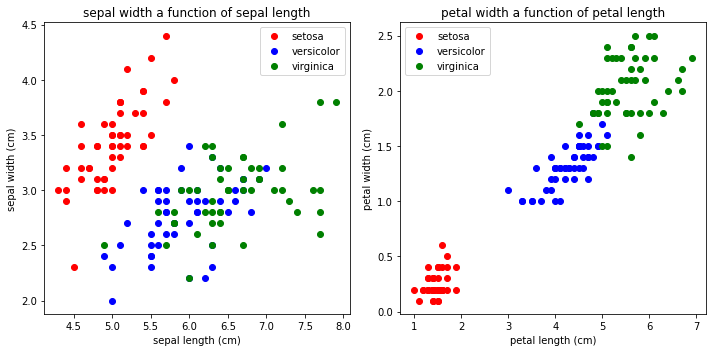

In [13]:
plt.rcParams['figure.figsize'] = [10,5]

plt.subplot(1,2,1)
plt.plot(iris0[:,0], iris0[:,1], 'ro', label = 'setosa')
plt.plot(iris1[:,0], iris1[:,1], 'bo', label = 'versicolor')
plt.plot(iris2[:,0], iris2[:,1], 'go', label = 'virginica')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title('sepal width a function of sepal length')
plt.legend(loc = 'upper right')

plt.subplot(1,2,2)
plt.plot(iris0[:,2], iris0[:,3], 'ro', label = 'setosa')
plt.plot(iris1[:,2], iris1[:,3], 'bo', label = 'versicolor')
plt.plot(iris2[:,2], iris2[:,3], 'go', label = 'virginica')
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.title('petal width a function of petal length')
plt.legend(loc = 'upper left')

plt.tight_layout()
plt.show()

Comparing sepal length and width shows a clear separation between setosae and the 2 other species.  
The plot showing petal width an length shows that a projection on either petal length or petal width gives a good clustering.  
On the other hand projecting on sepal width won't allow us to cluster the species very well (this result is in accordance with the covariance results).

## Using `pandas` to manipulate the data
Pandas is great to manipulate data in a Microsoft Excel like way.

In [14]:
import pandas as pd

# Create a dataframe with the four feature variables
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [15]:
# Add a new column with the species names, this is what we are going to try to predict
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Step 2: create training and test sets

Create a new column that for each row, generates a random number between 0 and 1, and if that value is less than or equal to .75, then sets the value of that cell as True and false otherwise. This is a quick and dirty way of randomly assigning some rows to be used as the training data and some as the test data.

In [16]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,is_train
0,5.1,3.5,1.4,0.2,setosa,True
1,4.9,3.0,1.4,0.2,setosa,True
2,4.7,3.2,1.3,0.2,setosa,True
3,4.6,3.1,1.5,0.2,setosa,True
4,5.0,3.6,1.4,0.2,setosa,True


In [17]:
# Create two new dataframes, one with the training rows, one with the test rows
train, test = df[df['is_train']==True], df[df['is_train']==False]

In [18]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 118
Number of observations in the test data: 32


In [19]:
# Create a list of the feature column's names
features = df.columns[:4]

# View features
features

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [37]:
# train['species'] contains the actual species names. Before we can use it,
# we need to convert each species name into a digit. So, in this case there
# are three species, which have been coded as 0, 1, or 2.
y_train = pd.factorize(train['species'])[0]

## Step 3: decision trees for the iris dataset
The method `tree.DecisionTreeClassifier()` from `scikit-learn` builds decision trees objects as follows:

In [21]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train[features], y)

# Using the whole dataset you may use directly:
#clf = clf.fit(iris.data, iris.target)

The `export_graphviz` exporter supports a variety of aesthetic options, including coloring nodes by their class (or value for regression) and using explicit variable and class names if desired. Jupyter notebooks also render these plots inline automatically:

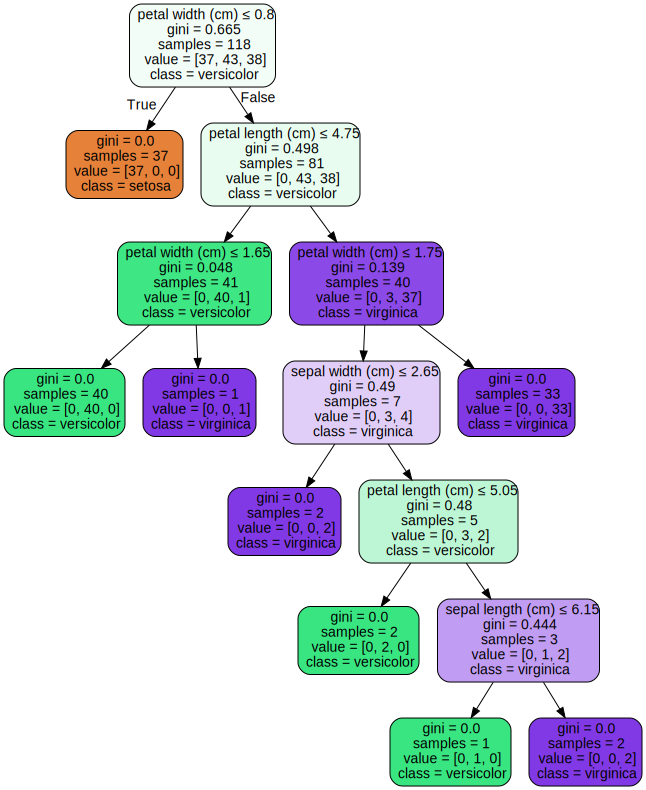

In [22]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

We can also export the tree in Graphviz format and  save the resulting graph in an output file iris.pdf:

In [23]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

'iris.pdf'

After being fitted, **the model can then be used to predict the class of samples**:

In [24]:
class_pred = clf.predict(iris.data[:1, :])
class_pred

C:\Users\Mohammad\anaconda3\envs\AMAL\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

## Exercise 1
1. Train the decision tree on the iris dataset and explain how one should read blocks in `graphviz` representation of the tree.

2. Plot the regions of decision with the points of the training set superimposed.

*Indication: you may find the function `plt.contourf` useful.

---
*Note on Gini index separation criterion*

At each node a binary decision is made on how to separate the dataset into two new datasets, the children nodes. The separation criterion is chosen using the Gini index by default: $\sum_{k=1}^{K}p_{m,k}(1 - p_{m,k}) $. If we code each observation as 1 for class $k$ and zero otherwise, the Gini criterion can be interpreted as the sum of variances over all classes.   
We could use a different node impurity measure (misclassification rate or cross-entropy for instance).  
  
1. This tree should be read from top to bottom. We can notice that, for a given node, as long as the samples are of different classes we continue splitting the data. We reach a leaf when all the samples are of the same class. We can change this behaviour using the the  `min_samples_leaf` parameter to train the model (default = 1).   
For each new value we want to predict,  we check at each note whether it verifies the assertion. It it does, we continue testing the value on the left child, if it doesn't, we continue on the right child. We iterate the check until we reach a leaf.  The class of the leaf gives the value its predicted class.

In [28]:
# stting the extremum values of the grids
x1_min, x1_max = train['sepal length (cm)'].min() - 1, train['sepal length (cm)'].max() + 1
x2_min, x2_max = train['sepal width (cm)'].min() - 1, train['sepal width (cm)'].max() + 1
x3_min, x3_max = train['petal length (cm)'].min() - 1, train['petal length (cm)'].max() + 1
x4_min, x4_max = train['petal width (cm)'].min() - 1, train['petal width (cm)'].max() + 1

In [29]:
# creating the 4 axis (4 features) samples
N_points = 20 # number of points on each axis
x1 = linspace(x1_min, x1_max, N_points)
x2 = linspace(x2_min, x2_max, N_points)
x3 = linspace(x3_min, x3_max, N_points)
x4 = linspace(x4_min, x4_max, N_points)

In [30]:
# creating the coordinates of the 4D space with a meshgrid
meshgrid = np.meshgrid(x1, x2, x3, x4)
all_coordinates = vstack((meshgrid[0].ravel(), meshgrid[1].ravel(), meshgrid[2].ravel(), meshgrid[3].ravel())).T

In [31]:
# creating the dataframe of all coordinates
df_coordinates = pd.DataFrame(data = all_coordinates, columns = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'])                                

We get the dataframe with all points in a 4D space.

In [32]:
df_coordinates.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,3.4,1.0,0.0,-0.900000
1,3.4,1.0,0.0,-0.668421
2,3.4,1.0,0.0,-0.436842
3,3.4,1.0,0.0,-0.205263
4,3.4,1.0,0.0,0.026316


Let's predict the plant class of all these points.

In [33]:
# predicting the class and adding the column to the dataframe
plot_pred = clf.predict(df_coordinates.values)
df_coordinates['predicted species'] = np.select([plot_pred == 0, plot_pred == 1, plot_pred == 2], ["setosa", "versicolor", "virginica"])
df_coordinates.head()

C:\Users\Mohammad\anaconda3\envs\AMAL\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),predicted species
0,3.4,1.0,0.0,-0.900000,setosa
1,3.4,1.0,0.0,-0.668421,setosa
2,3.4,1.0,0.0,-0.436842,setosa
3,3.4,1.0,0.0,-0.205263,setosa
4,3.4,1.0,0.0,0.026316,setosa


In [34]:
# selecting the data on class
train_setosa = df_coordinates.loc[df_coordinates['predicted species'] == 'setosa']
train_versicolor = df_coordinates.loc[df_coordinates['predicted species'] == 'versicolor']
train_virginica = df_coordinates.loc[df_coordinates['predicted species'] == 'virginica']

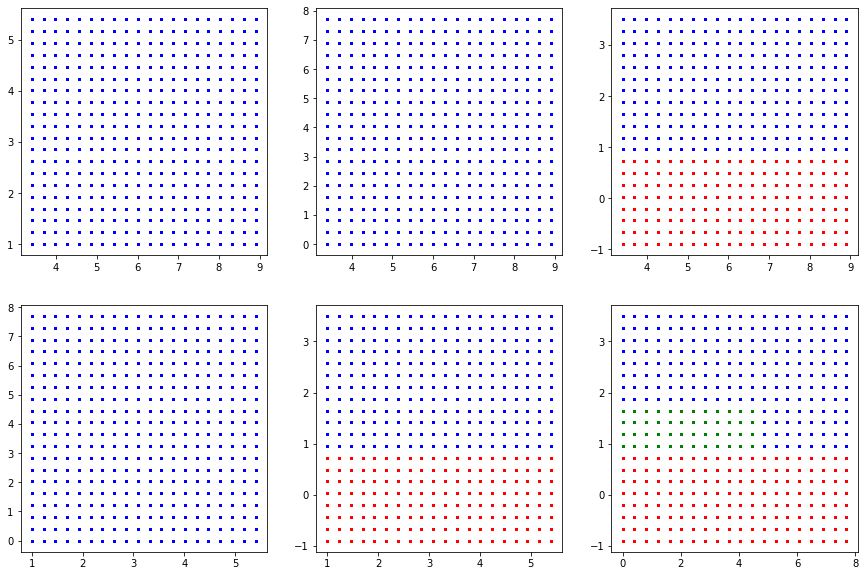

In [35]:
# plotting the boudaries
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
  plt.subplot(2,3,pairidx + 1)
  plt.plot(train_setosa.values[:,pair[0]],train_setosa.values[:,pair[1]], 'r^', markersize = 2)
  plt.plot(train_versicolor.values[:,pair[0]],train_versicolor.values[:,pair[1]], 'g.',markersize = 2)
  plt.plot(train_virginica.values[:,pair[0]],train_virginica.values[:,pair[1]], 'bo', markersize = 2)

plt.show()

Unfortunately we haven't been able to properly plot the regions of decision. We felt we had spent way too much time trying to make this work so we decided to leave it as is.

---

## Exercise 2
1. Build 2 different trees based on a sepal features (sepal lengths, sepal widths) vs petal features (petal lengths, petal widths) only: which features are the most discriminant?

2. Compare performances with those obtained using all features.

3. Try the same as above using the various splitting criterion available, Gini's index, classification error or cross-entropy. Comment on your results. 

---
Let's train the iris dataset on petal features and sepal features separately.

In [38]:
# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

# We only take the two corresponding features (sepal and petal)
X_sepal = train.values[:,0:2]
X_petal = train.values[:,2:4]

# Training two different trees, one using the sepal features, the other using the petal features
clf_sepal = tree.DecisionTreeClassifier().fit(X_sepal, y_train)
clf_petal = tree.DecisionTreeClassifier().fit(X_petal, y_train)

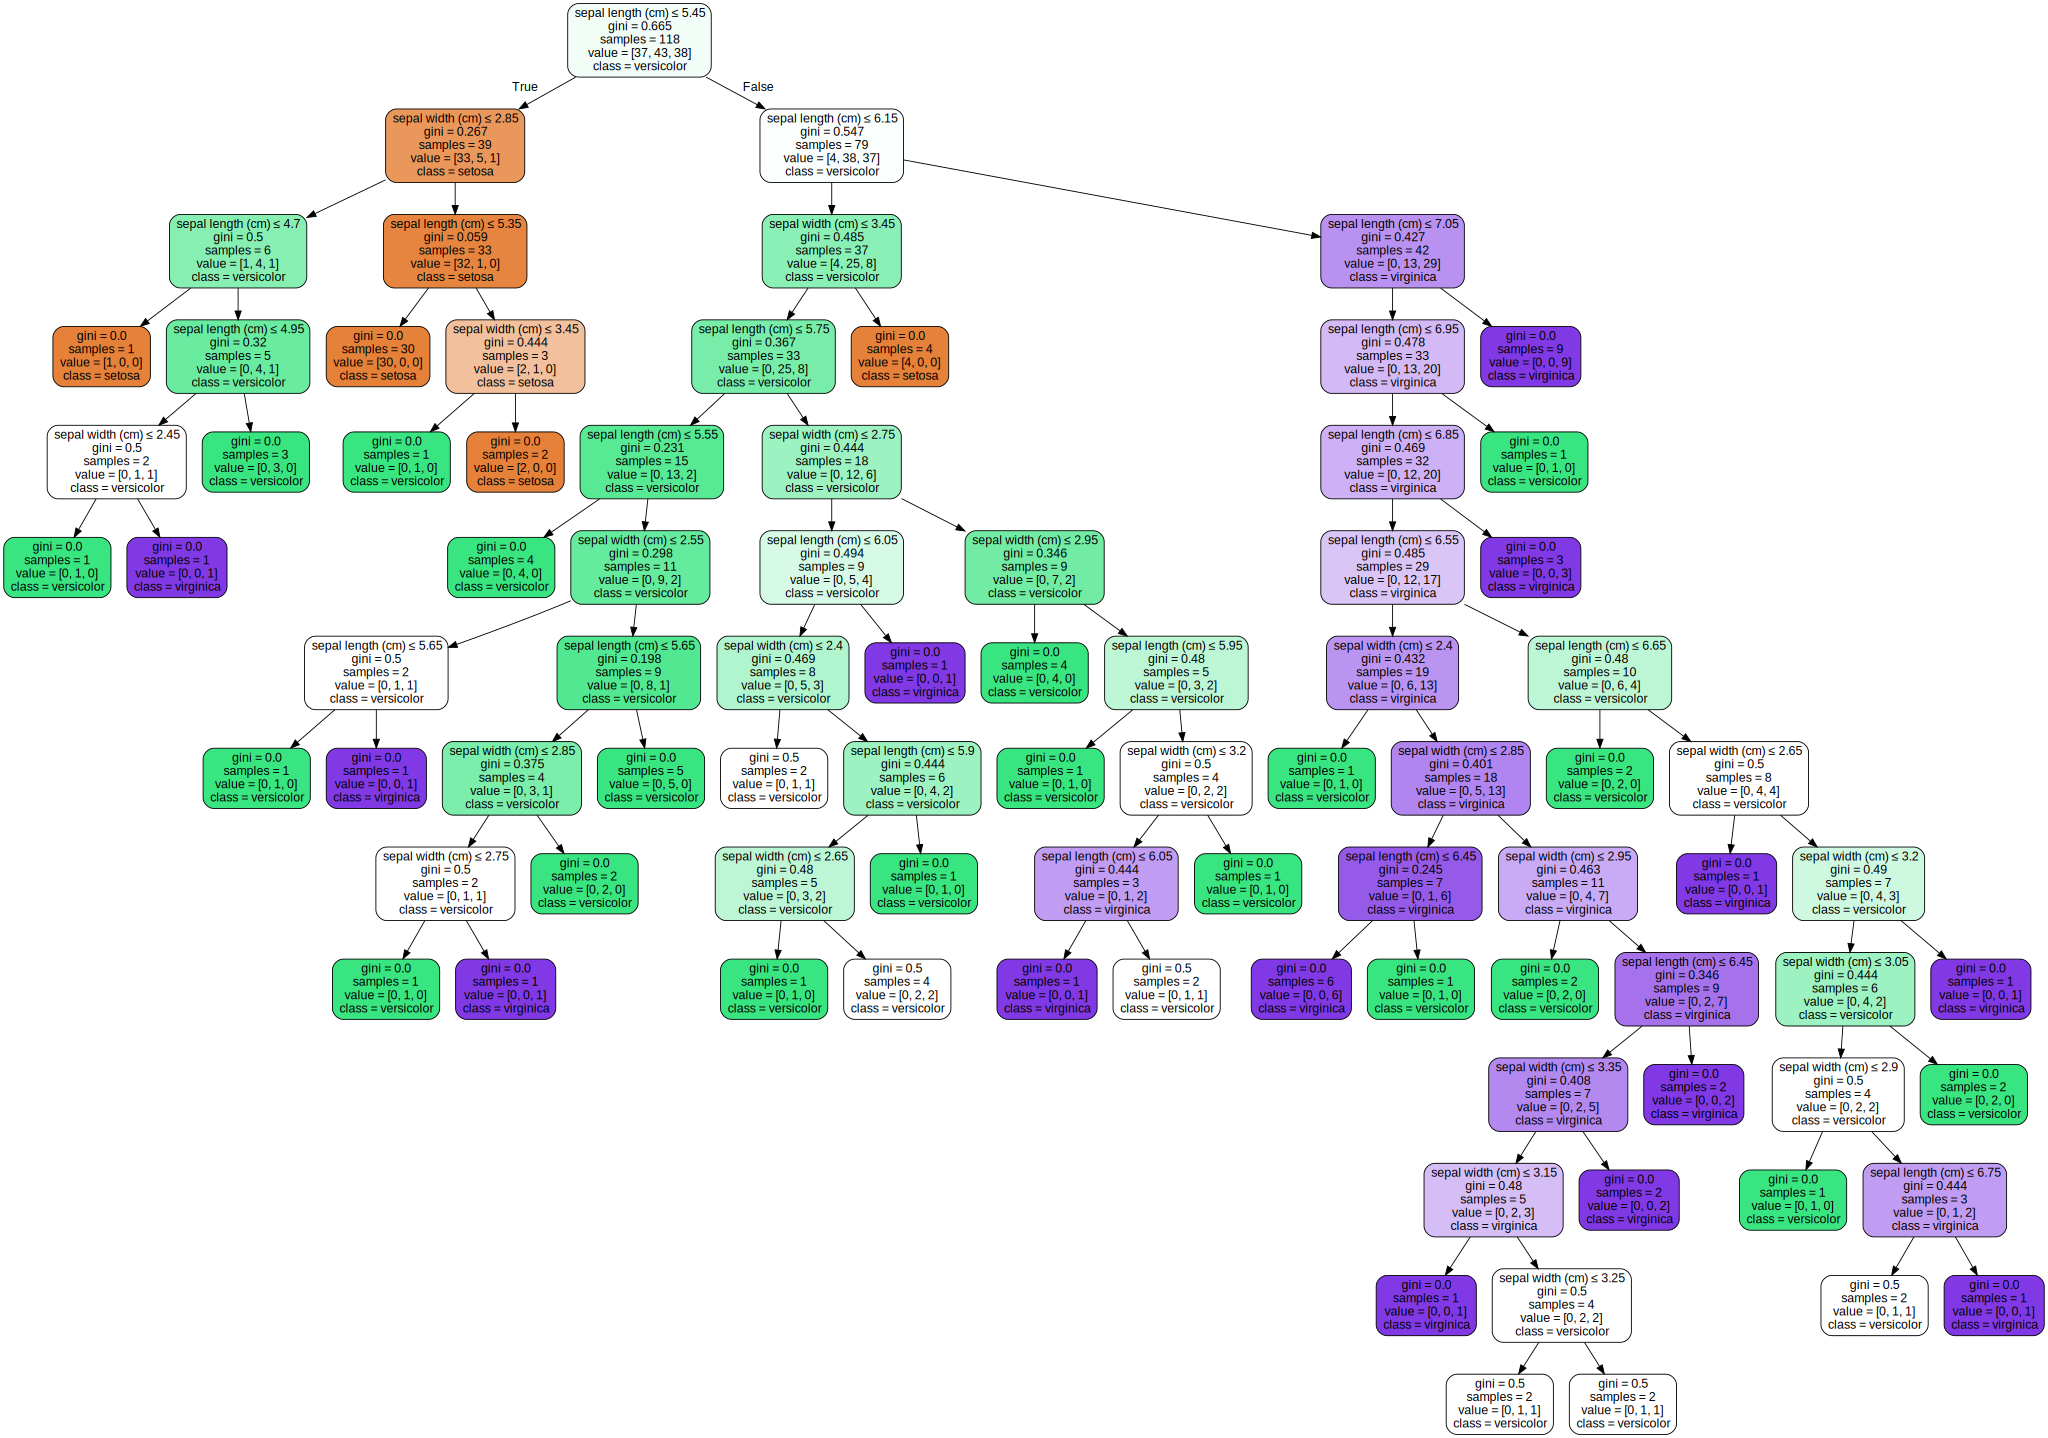

In [42]:
# Constructing the tree for sepal features 

dot_data_sepal = tree.export_graphviz(clf_sepal, out_file=None, 
                         feature_names=iris.feature_names[:2],  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph_sepal = graphviz.Source(dot_data_sepal)  
graph_sepal

This tree is very deep, we are overfitting the model.
We could prune the tree or lower the minimum sample per leaf to deal with the overfitting issue.

The last white leaves predict a class with a coin flip. Indeed they have the same amount of values from two different classes, so there is no majority. As a result, this tree has an error rate on the training set.

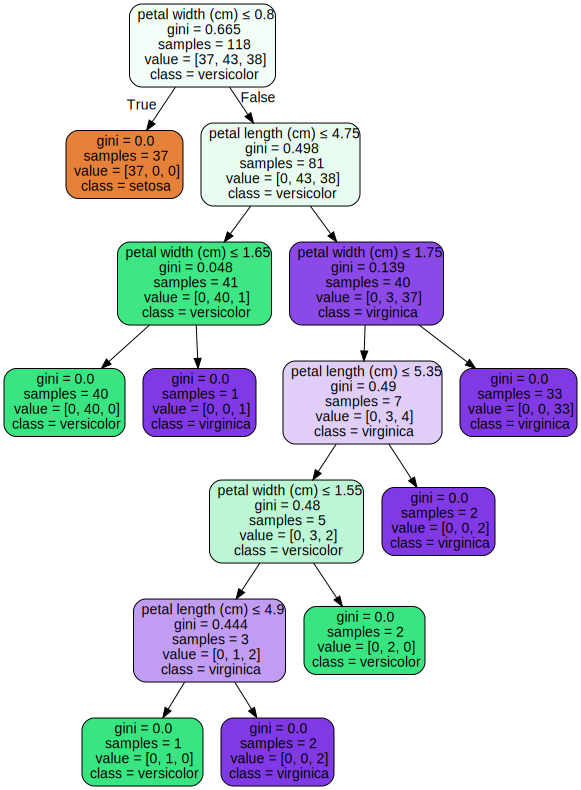

In [43]:
# Constructing the tree for petal features 

dot_data_petal = tree.export_graphviz(clf_petal, out_file=None, 
                         feature_names=iris.feature_names[2:4],  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph_petal = graphviz.Source(dot_data_petal)  
graph_petal

This tree is much shorter than the previous one and is completely deterministic.

In [44]:
# exporting the trees

graph_sepal.render("iris sepal features") 
graph_petal.render("iris petal features") 

'iris petal features.pdf'

Let's show the 2D classification boundaries of the two training models.

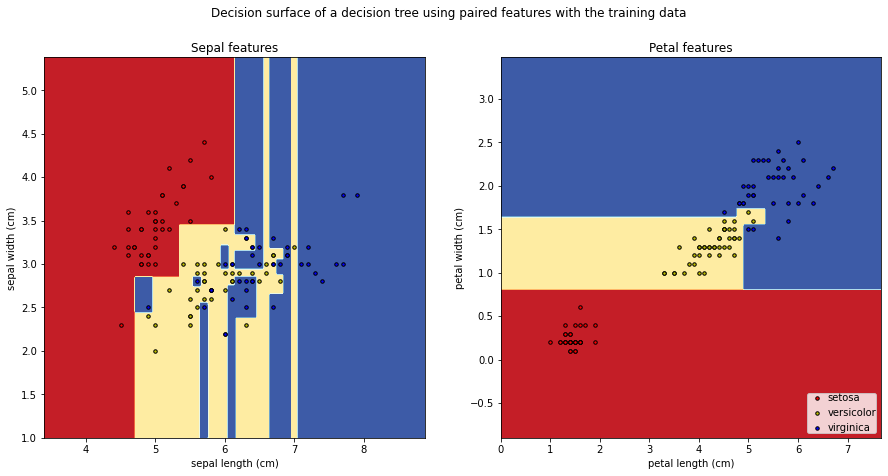

In [45]:
plt.rcParams['figure.figsize'] = [15,7]

# Plot the decision boundary using the sepal features
plt.subplot(1, 2, 1)

x_sepal_min, x_sepal_max = X_sepal[:, 0].min() - 1, X_sepal[:, 0].max() + 1
y_sepal_min, y_sepal_max = X_sepal[:, 1].min() - 1, X_sepal[:, 1].max() + 1
xx_sepal, yy_sepal = np.meshgrid(np.arange(x_sepal_min, x_sepal_max, plot_step),
                     np.arange(y_sepal_min, y_sepal_max, plot_step))

Z_sepal = clf_sepal.predict(np.c_[xx_sepal.ravel(), yy_sepal.ravel()])
Z_sepal = Z_sepal.reshape(xx_sepal.shape)
cs_sepal = plt.contourf(xx_sepal, yy_sepal, Z_sepal, cmap=plt.cm.RdYlBu)

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Sepal features")

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_train == i)
    plt.scatter(X_sepal[idx, 0], X_sepal[idx, 1], c=color, label=iris.target_names[i],
                cmap=plt.cm.RdYlBu, edgecolor='black', s=12)


    
# Plot the decision boundary using the petal features
plt.subplot(1, 2, 2)

x_petal_min, x_petal_max = X_petal[:, 0].min() - 1, X_petal[:, 0].max() + 1
y_petal_min, y_petal_max = X_petal[:, 1].min() - 1, X_petal[:, 1].max() + 1
xx_petal, yy_petal = np.meshgrid(np.arange(x_petal_min, x_petal_max, plot_step),
                     np.arange(y_petal_min, y_petal_max, plot_step))

Z_petal = clf_petal.predict(np.c_[xx_petal.ravel(), yy_petal.ravel()])
Z_petal = Z_petal.reshape(xx_petal.shape)
cs_petal = plt.contourf(xx_petal, yy_petal, Z_petal, cmap=plt.cm.RdYlBu)

plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
plt.title("Petal features")

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_train == i)
    plt.scatter(X_petal[idx, 0], X_petal[idx, 1], c=color, label=iris.target_names[i],
                cmap=plt.cm.RdYlBu, edgecolor='black', s=12)

plt.suptitle("Decision surface of a decision tree using paired features with the training data")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")


plt.show()

Just as we thought at the start, the petal features are far more discriminant than the sepal features. This is shown by how well delimited are the decision regions. Judging by the aspect of the decision regions in the first model, we may assume that it will hardly be relevent to classify a different data set (overfitting).

Let's predict on the test set with a tree trained on all 4 features and 2 trees trained on sepal features and petal features.

In [46]:
all_class_predict = clf.predict(test[features])
sepal_class_predict = clf_sepal.predict(test[test.columns[0:2]])
petal_class_predict = clf_petal.predict(test[test.columns[2:4]])

C:\Users\Mohammad\anaconda3\envs\AMAL\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Mohammad\anaconda3\envs\AMAL\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


First let us retrieve the targets for the test set.

In [47]:
# test['species'] contains the actual species names. Before we can use it,
# we need to convert each species name into a digit. So, in this case there
# are three species, which have been coded as 0, 1, or 2.
y_test = pd.factorize(test['species'])[0]

Let us now compute the prediction errors.

In [48]:
# selecting the non zeros values and counting them

N_test = len(test)

error = np.count_nonzero(all_class_predict - y_test) / N_test
error_sepal = np.count_nonzero(sepal_class_predict - y_test) / N_test
error_petal = np.count_nonzero(petal_class_predict - y_test) / N_test

In [49]:
print("Error on the test set with all the features : ", error)
print("Error on the test set with the sepal features : ", error_sepal)
print("Error on the test set with the petal features : ", error_petal)

Error on the test set with all the features :  0.0625
Error on the test set with the sepal features :  0.25
Error on the test set with the petal features :  0.03125


We see that the test error we get with the tree based solely on the petal features error is twice as low as test error with the very first tree. This confirms the intuition we had in the begining by computing the covariance matrix. We saw that the sepal features were not very correlated with the others, whereas the petal features were. In comparison, the results with the tree based on the sepal features are abysmal.

Let us see how the test data are spread out on the decision surfaces.

In [50]:
# We only take the two corresponding features (sepal and petal)
X_test_sepal = test.values[:,0:2]
X_test_petal = test.values[:,2:4]

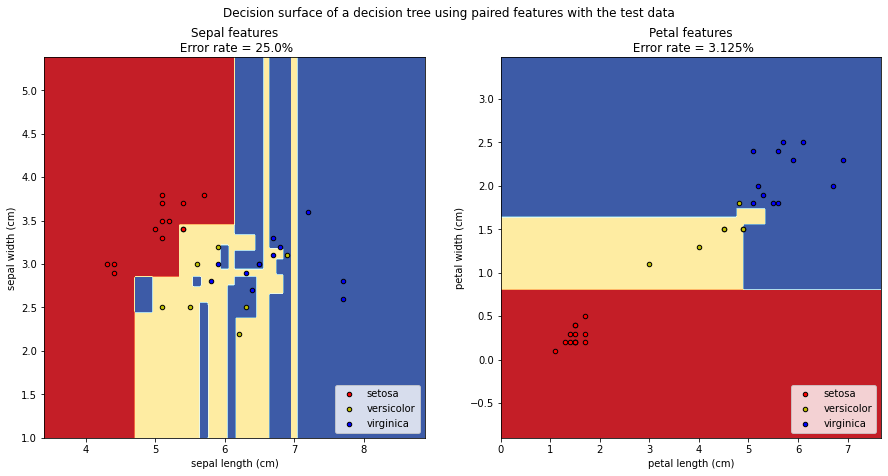

In [51]:
#  Plot the decision boundary using the sepal features
plt.subplot(1, 2, 1)

x_sepal_min, x_sepal_max = X_sepal[:, 0].min() - 1, X_sepal[:, 0].max() + 1
y_sepal_min, y_sepal_max = X_sepal[:, 1].min() - 1, X_sepal[:, 1].max() + 1
xx_sepal, yy_sepal = np.meshgrid(np.arange(x_sepal_min, x_sepal_max, plot_step),
                     np.arange(y_sepal_min, y_sepal_max, plot_step))

Z_sepal = clf_sepal.predict(np.c_[xx_sepal.ravel(), yy_sepal.ravel()])
Z_sepal = Z_sepal.reshape(xx_sepal.shape)
cs_sepal = plt.contourf(xx_sepal, yy_sepal, Z_sepal, cmap=plt.cm.RdYlBu)

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Sepal features\n Error rate = " + str(error_sepal * 100) + "%")

# Plot the test points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_test == i)
    plt.scatter(X_test_sepal[idx, 0], X_test_sepal[idx, 1], c=color, label=iris.target_names[i],
                cmap=plt.cm.RdYlBu, edgecolor='black', s=20)

plt.legend(loc='lower right')
plt.axis("tight")

# Plot the decision boundary using the petal features
plt.subplot(1, 2, 2)

x_petal_min, x_petal_max = X_petal[:, 0].min() - 1, X_petal[:, 0].max() + 1
y_petal_min, y_petal_max = X_petal[:, 1].min() - 1, X_petal[:, 1].max() + 1
xx_petal, yy_petal = np.meshgrid(np.arange(x_petal_min, x_petal_max, plot_step),
                     np.arange(y_petal_min, y_petal_max, plot_step))

Z_petal = clf_petal.predict(np.c_[xx_petal.ravel(), yy_petal.ravel()])
Z_petal = Z_petal.reshape(xx_petal.shape)
cs_petal = plt.contourf(xx_petal, yy_petal, Z_petal, cmap=plt.cm.RdYlBu)

plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
plt.title("Petal features\n Error rate = " + str(error_petal * 100) + "%")

# Plot the test points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_test == i)
    plt.scatter(X_test_petal[idx, 0], X_test_petal[idx, 1], c=color, label=iris.target_names[i],
                cmap=plt.cm.RdYlBu, edgecolor='black', s=20)

plt.suptitle("Decision surface of a decision tree using paired features with the test data")
plt.legend(loc='lower right', facecolor = 'white')
plt.axis("tight")


plt.show()

As expected, on the one hand the tree built using only the sepal features has a hard time classifying the test data. Up to a quarter of this dataset is misclassified. On the other hand, the tree built using only the petal features yields results even better than the ones we had with the first tree.

### Let's try the entropy splitting criterion.

Let's train the datasets on all features, sepal features and petal features.

In [52]:
clf_entr = tree.DecisionTreeClassifier(criterion ="entropy").fit(train[features], y_train)
clf_sepal_entr = tree.DecisionTreeClassifier(criterion ="entropy").fit(X_sepal, y_train)
clf_petal_entr = tree.DecisionTreeClassifier(criterion ="entropy").fit(X_petal, y_train)

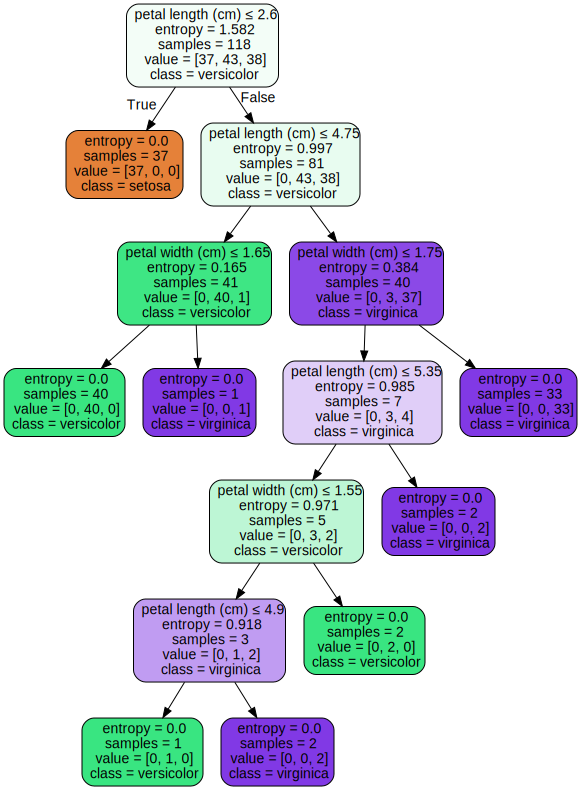

In [53]:
dot_data_entr = tree.export_graphviz(clf_entr, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)

graph_entr = graphviz.Source(dot_data_entr)  
graph_entr

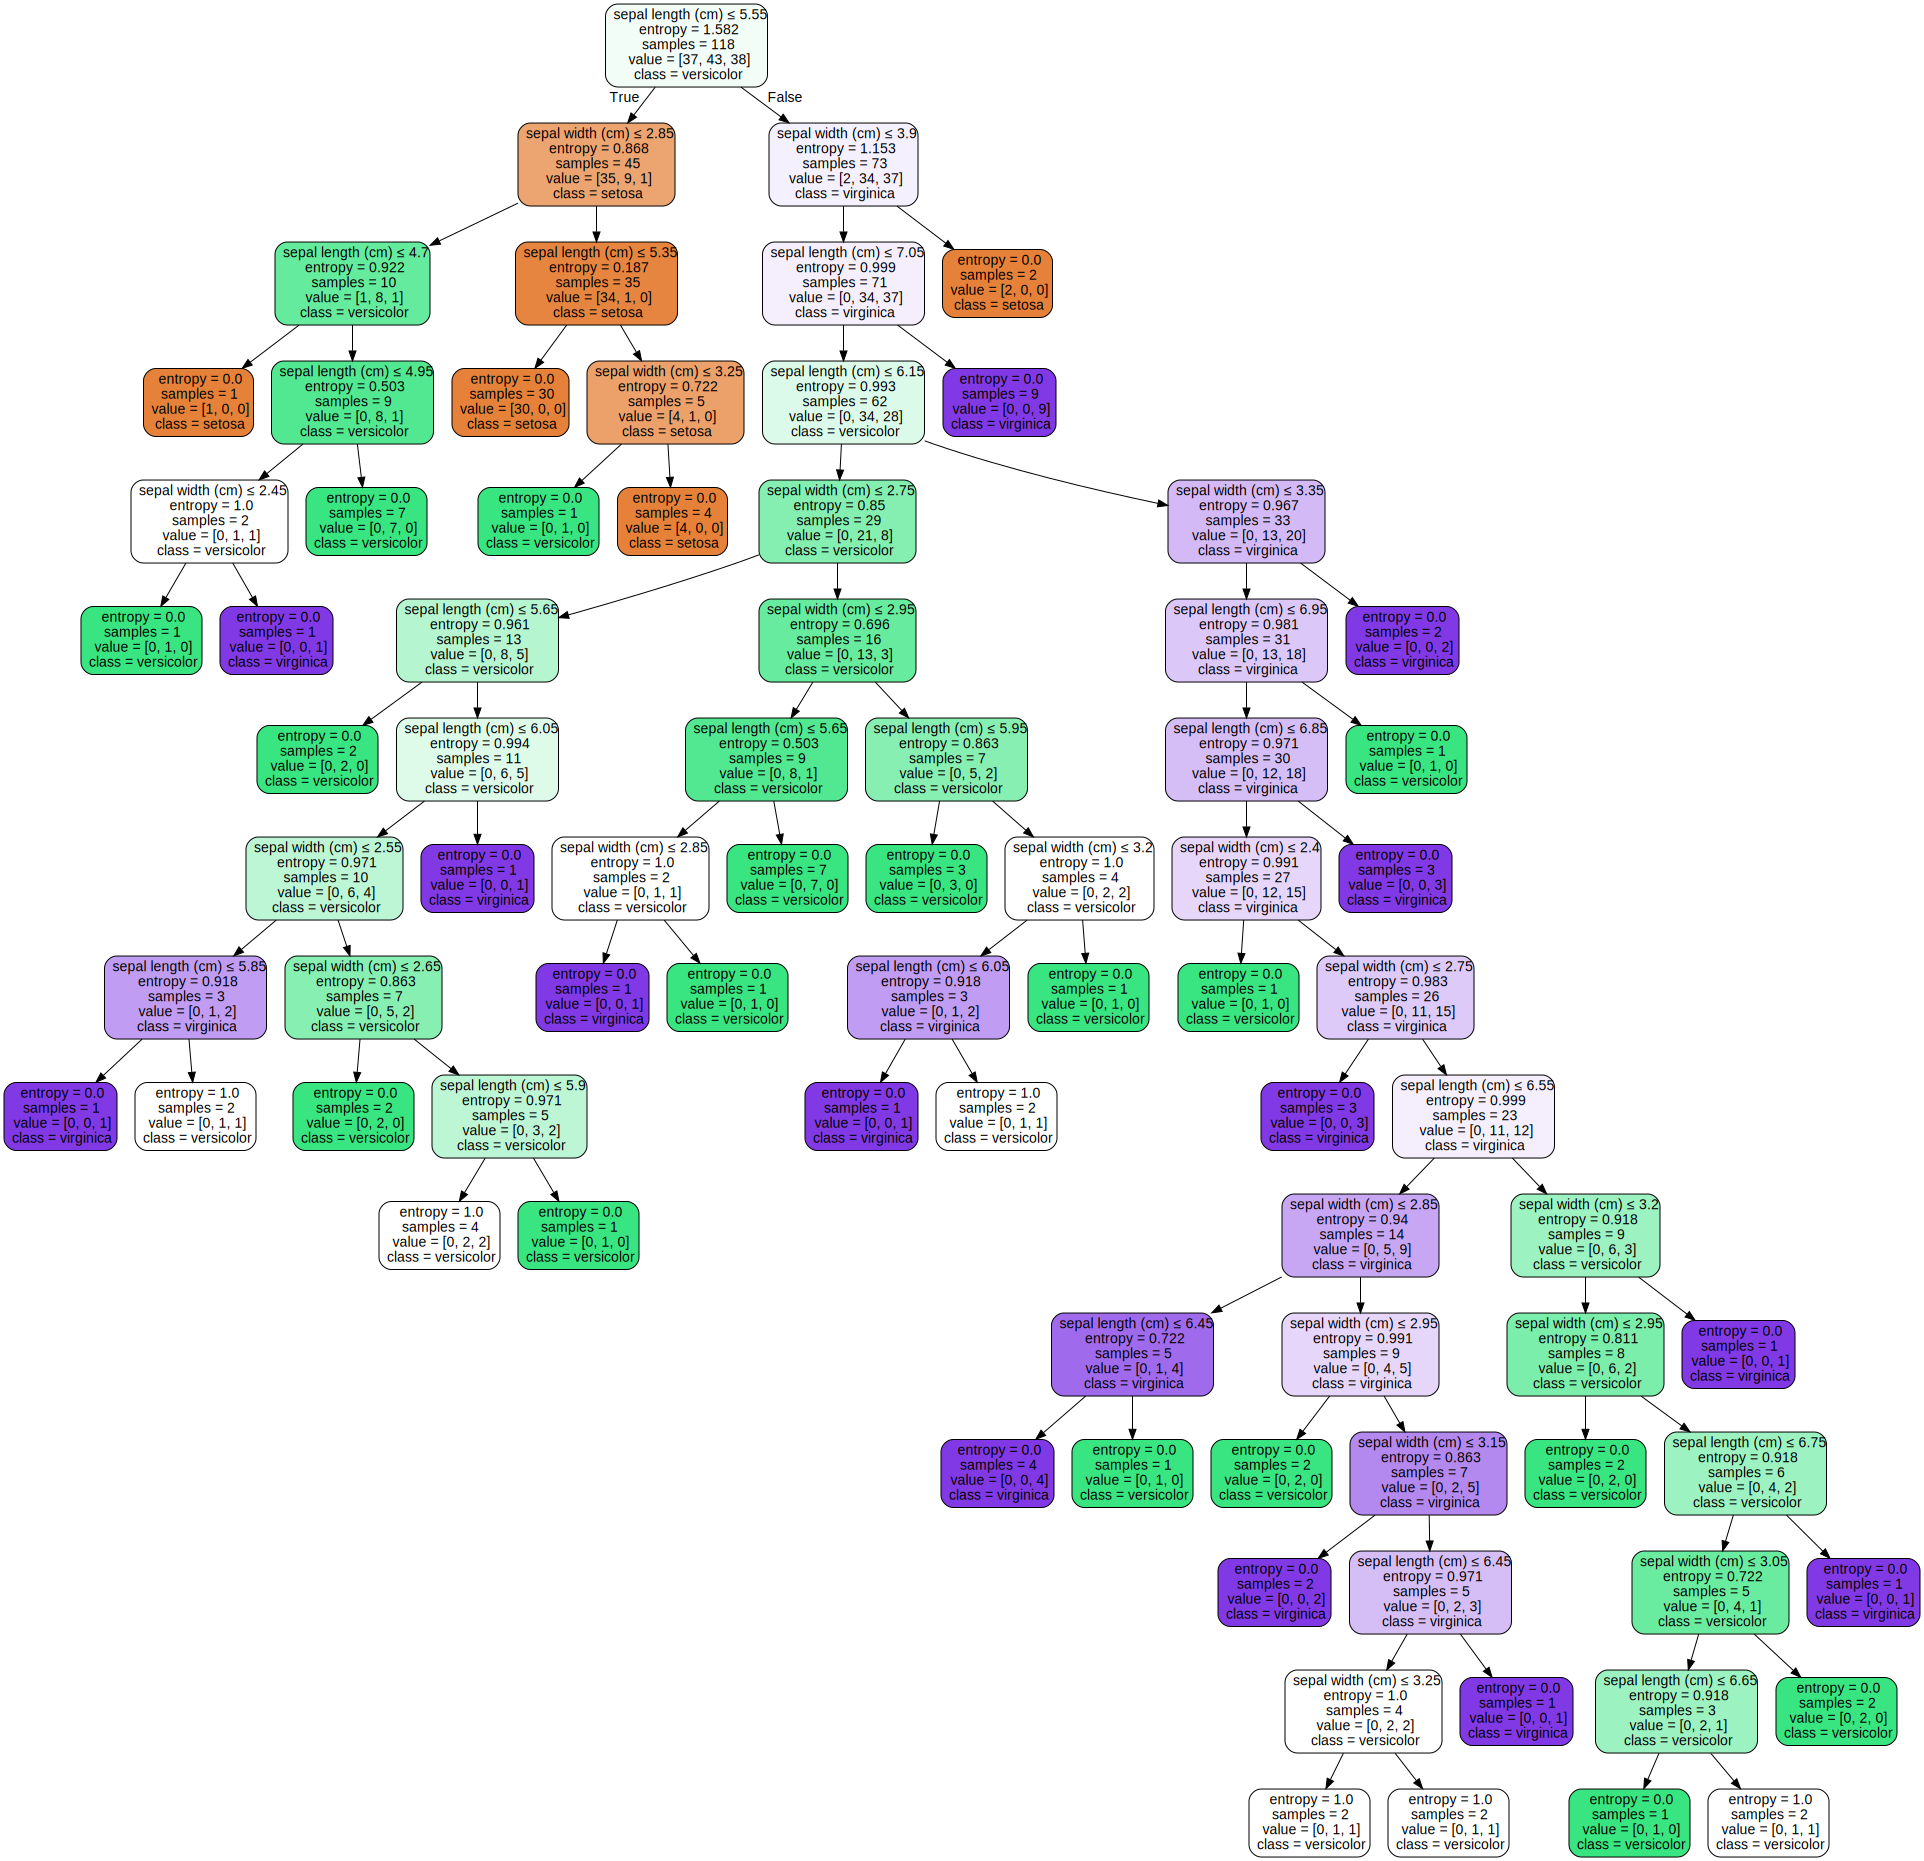

In [54]:
dot_data_sepal_entr = tree.export_graphviz(clf_sepal_entr, out_file=None, 
                         feature_names=iris.feature_names[:2],  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)

graph_sepal_entr = graphviz.Source(dot_data_sepal_entr)  
graph_sepal_entr

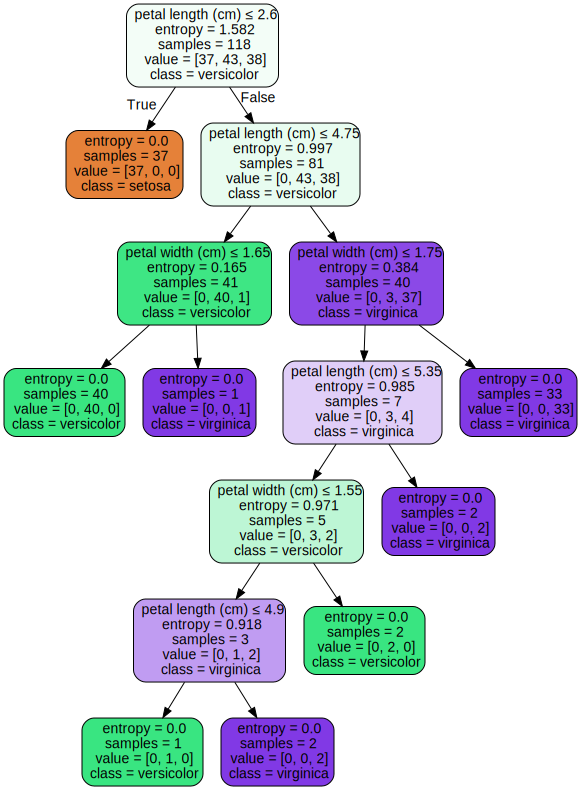

In [55]:
dot_data_petal_entr = tree.export_graphviz(clf_petal_entr, out_file=None, 
                         feature_names=iris.feature_names[2:4],  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)

graph_petal_entr = graphviz.Source(dot_data_petal_entr)  
graph_petal_entr

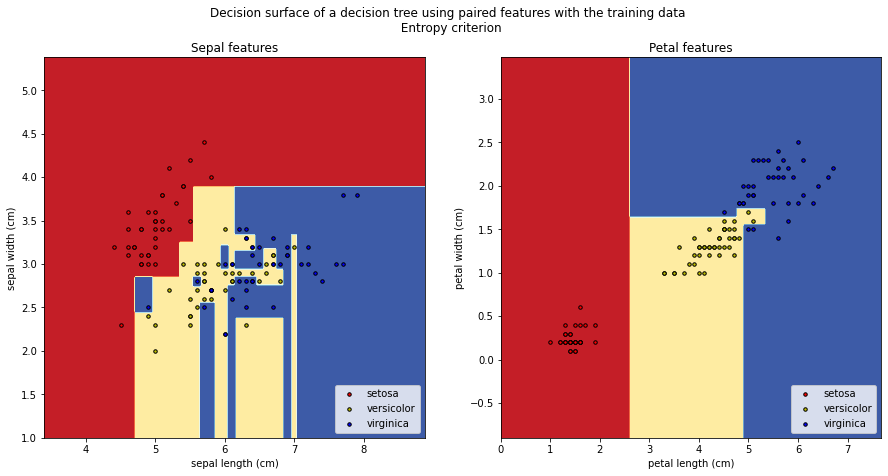

In [56]:
plt.rcParams['figure.figsize'] = [15,7]

# Plot the decision boundary using the sepal features
plt.subplot(1, 2, 1)

x_sepal_min, x_sepal_max = X_sepal[:, 0].min() - 1, X_sepal[:, 0].max() + 1
y_sepal_min, y_sepal_max = X_sepal[:, 1].min() - 1, X_sepal[:, 1].max() + 1
xx_sepal, yy_sepal = np.meshgrid(np.arange(x_sepal_min, x_sepal_max, plot_step),
                     np.arange(y_sepal_min, y_sepal_max, plot_step))

Z_sepal = clf_sepal_entr.predict(np.c_[xx_sepal.ravel(), yy_sepal.ravel()])
Z_sepal = Z_sepal.reshape(xx_sepal.shape)
cs_sepal = plt.contourf(xx_sepal, yy_sepal, Z_sepal, cmap=plt.cm.RdYlBu)

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Sepal features")

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_train == i)
    plt.scatter(X_sepal[idx, 0], X_sepal[idx, 1], c=color, label=iris.target_names[i],
                cmap=plt.cm.RdYlBu, edgecolor='black', s=12)

plt.legend(loc='lower right')

    
# Plot the decision boundary using the petal features
plt.subplot(1, 2, 2)

x_petal_min, x_petal_max = X_petal[:, 0].min() - 1, X_petal[:, 0].max() + 1
y_petal_min, y_petal_max = X_petal[:, 1].min() - 1, X_petal[:, 1].max() + 1
xx_petal, yy_petal = np.meshgrid(np.arange(x_petal_min, x_petal_max, plot_step),
                     np.arange(y_petal_min, y_petal_max, plot_step))

Z_petal = clf_petal_entr.predict(np.c_[xx_petal.ravel(), yy_petal.ravel()])
Z_petal = Z_petal.reshape(xx_petal.shape)
cs_petal = plt.contourf(xx_petal, yy_petal, Z_petal, cmap=plt.cm.RdYlBu)

plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
plt.title("Petal features")

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_train == i)
    plt.scatter(X_petal[idx, 0], X_petal[idx, 1], c=color, label=iris.target_names[i],
                cmap=plt.cm.RdYlBu, edgecolor='black', s=12)

plt.suptitle("Decision surface of a decision tree using paired features with the training data \n Entropy criterion")
plt.legend(loc='lower right')
plt.axis("tight")


plt.show()

Let's predict on the test set with a tree trained on all 4 features and 2 trees trained on sepal features and petal features.

In [57]:
all_class_predict_entr = clf_entr.predict(test[test.columns[:4]])
sepal_class_predict_entr = clf_sepal_entr.predict(test[test.columns[0:2]])
petal_class_predict_entr = clf_petal_entr.predict(test[test.columns[2:4]])

C:\Users\Mohammad\anaconda3\envs\AMAL\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Mohammad\anaconda3\envs\AMAL\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [58]:
# selecting the non zeros values and counting them

error_entr = np.count_nonzero(all_class_predict_entr - y_test) / N_test
error_sepal_entr = np.count_nonzero(sepal_class_predict_entr - y_test) / N_test
error_petal_entr = np.count_nonzero(petal_class_predict_entr - y_test) / N_test

Here is the error on the test set with the entropy splitting criterion.

In [59]:
print("Error on test set with training on all features : ", error_entr)
print("Error on test set with training on sepal features : ", error_sepal_entr)
print("Error on test set with training on petal features : ", error_petal_entr)

Error on test set with training on all features :  0.03125
Error on test set with training on sepal features :  0.21875
Error on test set with training on petal features :  0.03125


Here is the error on the test set with the gini splitting criterion.

In [61]:
print("Error on test set with training on all features : ", error)
print("Error on test set with training on sepal features : ", error_sepal)
print("Error on test set with training on petal features : ", error_petal)

Error on test set with training on all features :  0.0625
Error on test set with training on sepal features :  0.25
Error on test set with training on petal features :  0.03125


We can notice that the error is rate is lower using the entropy criterion for the trees built with all the features and the sepal features but is the same for the trees built with the petal features. We cannot really explain why though.

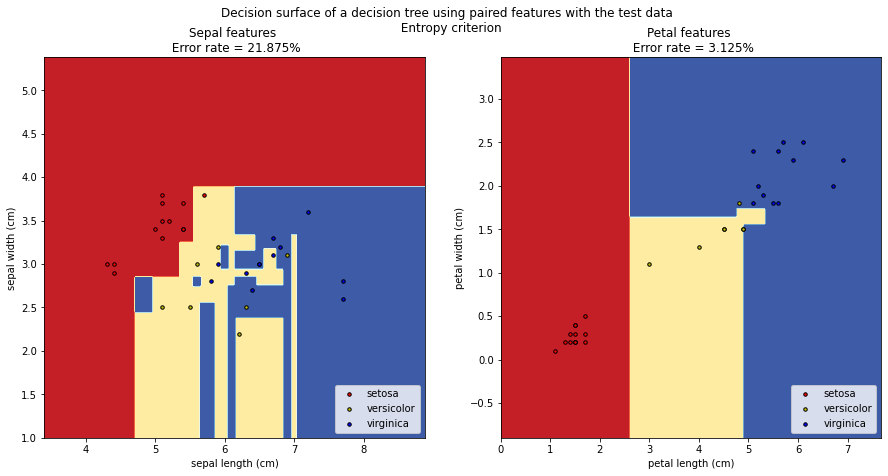

In [62]:
plt.rcParams['figure.figsize'] = [15,7]

# Plot the decision boundary using the sepal features
plt.subplot(1, 2, 1)

x_sepal_min, x_sepal_max = X_sepal[:, 0].min() - 1, X_sepal[:, 0].max() + 1
y_sepal_min, y_sepal_max = X_sepal[:, 1].min() - 1, X_sepal[:, 1].max() + 1
xx_sepal, yy_sepal = np.meshgrid(np.arange(x_sepal_min, x_sepal_max, plot_step),
                     np.arange(y_sepal_min, y_sepal_max, plot_step))

Z_sepal = clf_sepal_entr.predict(np.c_[xx_sepal.ravel(), yy_sepal.ravel()])
Z_sepal = Z_sepal.reshape(xx_sepal.shape)
cs_sepal = plt.contourf(xx_sepal, yy_sepal, Z_sepal, cmap=plt.cm.RdYlBu)

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Sepal features \n Error rate = " + str(error_sepal_entr * 100) + "%")

# Plot the test points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_test == i)
    plt.scatter(X_test_sepal[idx, 0], X_test_sepal[idx, 1], c=color, label=iris.target_names[i],
                cmap=plt.cm.RdYlBu, edgecolor='black', s=12)

plt.legend(loc='lower right')

    
# Plot the decision boundary using the petal features
plt.subplot(1, 2, 2)

x_petal_min, x_petal_max = X_petal[:, 0].min() - 1, X_petal[:, 0].max() + 1
y_petal_min, y_petal_max = X_petal[:, 1].min() - 1, X_petal[:, 1].max() + 1
xx_petal, yy_petal = np.meshgrid(np.arange(x_petal_min, x_petal_max, plot_step),
                     np.arange(y_petal_min, y_petal_max, plot_step))

Z_petal = clf_petal_entr.predict(np.c_[xx_petal.ravel(), yy_petal.ravel()])
Z_petal = Z_petal.reshape(xx_petal.shape)
cs_petal = plt.contourf(xx_petal, yy_petal, Z_petal, cmap=plt.cm.RdYlBu)

plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
plt.title("Petal features \n Error rate = " + str(error_petal_entr * 100) + "%")

# Plot the test points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_test == i)
    plt.scatter(X_test_petal[idx, 0], X_test_petal[idx, 1], c=color, label=iris.target_names[i],
                cmap=plt.cm.RdYlBu, edgecolor='black', s=12)

plt.suptitle("Decision surface of a decision tree using paired features with the test data \n Entropy criterion")
plt.legend(loc='lower right')
plt.axis("tight")


plt.show()

With either entropy or gini criterion, we get different trees but in the end we get similar error rates.

### Going further ahead (not mandatory) 
Try the same approach adapted to another toy dataset from `scikit-learn` described at:
http://scikit-learn.org/stable/datasets/index.html

Play with another dataset available at:
http://archive.ics.uci.edu/ml/datasets.html

## Step 4: Random forests
Go to 

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

for a documentation about the `RandomForestClassifier` provided by `scikit-learn`.

Since target values must be integers, we first need to transform labels into numbers as below.

In [63]:
# train['species'] contains the actual species names. Before we can use it,
# we need to convert each species name into a digit. So, in this case there
# are three species, which have been coded as 0, 1, or 2.
y = pd.factorize(train['species'])[0]

# View target
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [66]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
rf = RandomForestClassifier(n_jobs=2, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
rf.fit(train[features], y_train)

RandomForestClassifier(n_jobs=2, random_state=0)

**Make predictions** and create actual english names for the plants for each predicted plant class:

In [67]:
preds = rf.predict(test[features])
preds_names = pd.Categorical.from_codes(preds, iris.target_names)
preds_names

['setosa', 'setosa', 'setosa', 'setosa', 'setosa', ..., 'virginica', 'virginica', 'virginica', 'virginica', 'virginica']
Length: 32
Categories (3, object): ['setosa', 'versicolor', 'virginica']

### Create a confusion matrix

In [68]:
# Create confusion matrix unsing pandas:
pd.crosstab(test['species'], preds, rownames=['Actual Species'], colnames=['Predicted Species'])

Predicted Species,0,1,2
Actual Species,,,
setosa,13,0,0
versicolor,0,5,2
virginica,0,0,12


## Feature selection using random forests byproducts

One of the interesting use cases for random forest is feature selection. One of the byproducts of trying lots of decision tree variations is that you can examine which variables are working best/worst in each tree.

When a certain tree uses one variable and another doesn't, you can compare the value lost or gained from the inclusion/exclusion of that variable. The good random forest implementations are going to do that for you, so all you need to do is know which method or variable to look at.

### View feature importance
While we don't get regression coefficients like with ordinary least squares (OLS), we do get a score telling us how important each feature was in classifying. This is one of the most powerful parts of random forests, because we can clearly see that petal width was more important in classification than sepal width.


In [69]:
# View a list of the features and their importance scores
list(zip(train[features], rf.feature_importances_))

[('sepal length (cm)', 0.08474010289429795),
 ('sepal width (cm)', 0.022461263894393204),
 ('petal length (cm)', 0.4464851467243143),
 ('petal width (cm)', 0.4463134864869946)]

## Exercise 3
1. Comment on the feature importances with respect to your previous observations on decision trees above.

2. Extract and visualize 5 trees belonging to the random forest using the attribute `estimators_` of the trained random forest classifier. Compare them. *Note that you may code a loop on extracted trees.*

3. Study the influence of parameters like `max_depth`, `min_samples_leaf` and `min_samples_split`. Try to optimize them and explain your approach and choices.

4. How is estimated the prediction error of a random forest ?
*Indication: have a look at parameter `oob_score`.*
What are out-of-bag samples ?

5. What should you do when classes are not balanced in the dataset ? (that is when there are much more examples of one class than another)

---


1. On feature importance

In our previous observations we had petal width and length as the most important feature (they are the feature we separate the dataset on) and sepal width and length after.

Let's compute the features importances with skicit-learn.


In [70]:
rf.feature_importances_

array([0.0847401 , 0.02246126, 0.44648515, 0.44631349])

Here the feature importance is computed with the Gini criterion. The results above give the quality of the partition on each feature. Therfore the features are as follow from most important to less important:
- petal width
- petal length
- sepal length
- sepal width

2. Let's observe 5 single trees from the training of random forest.

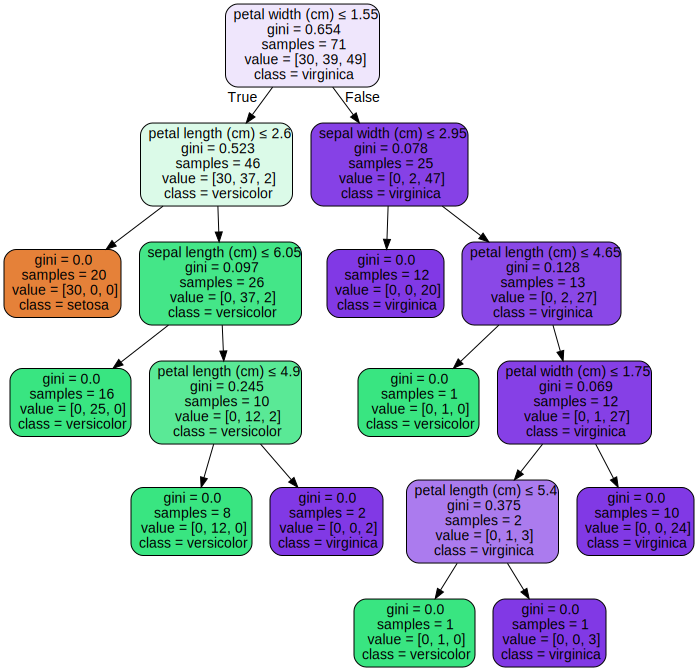

In [71]:
i = 0
  
# Extract single tree
estimator = rf.estimators_[i]

dot_data_rf = tree.export_graphviz(estimator, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)
graphviz.Source(dot_data_rf)

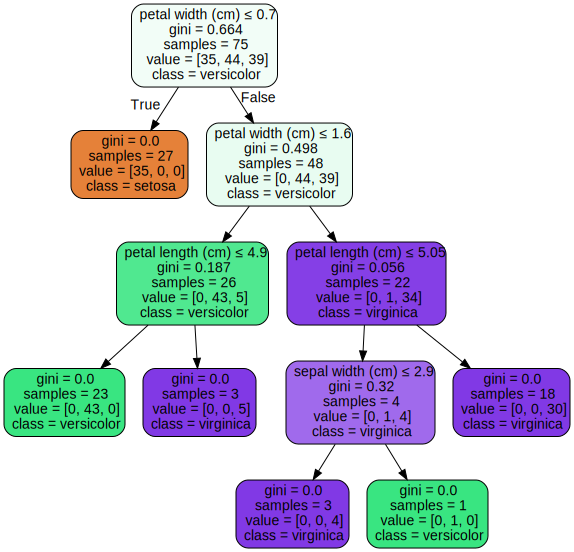

In [72]:
i = 1
  
# Extract single tree
estimator = rf.estimators_[i]

dot_data_rf = tree.export_graphviz(estimator, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)
graphviz.Source(dot_data_rf)

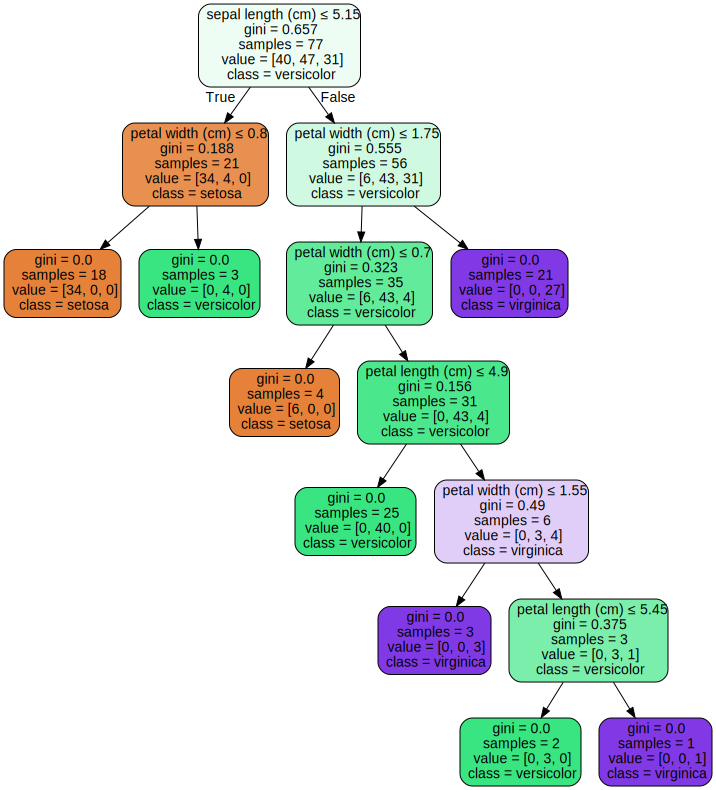

In [73]:
i = 2
  
# Extract single tree
estimator = rf.estimators_[i]

dot_data_rf = tree.export_graphviz(estimator, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)
graphviz.Source(dot_data_rf)

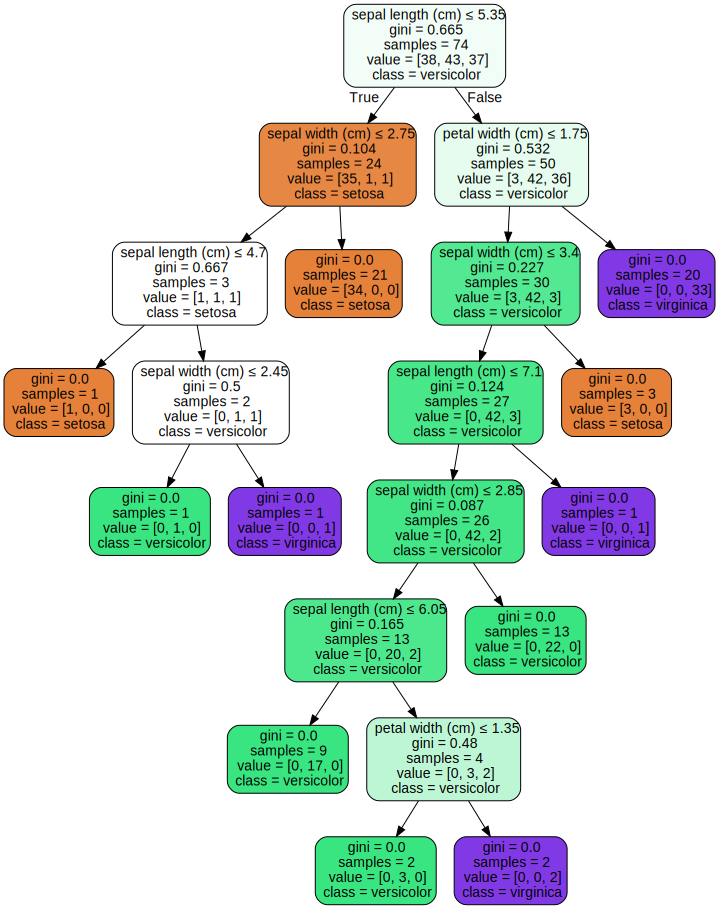

In [74]:
i = 3
  
# Extract single tree
estimator = rf.estimators_[i]

dot_data_rf = tree.export_graphviz(estimator, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)
graphviz.Source(dot_data_rf) 

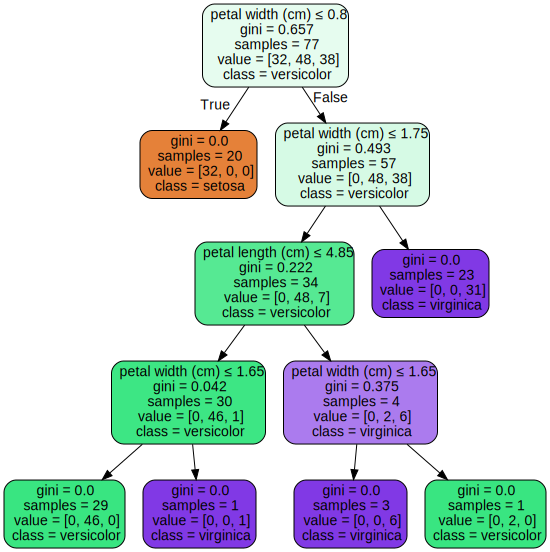

In [75]:
i = 4
  
# Extract single tree
estimator = rf.estimators_[i]

dot_data_rf = tree.export_graphviz(estimator, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)
graphviz.Source(dot_data_rf) 

We can notice that all these trees are different. The first feature to discriminate is not even the same in all trees.

Let's now use different parameters for the random forest. We set the random_state parameter from rf to False to get an estimation of the error on each value of parameter tested.

Let's test the tree depth.

In [76]:
N_loop = 10 # number of tests on each max_depth value
error_depth = np.zeros((N_loop,7))

# iterating on the different max_depth values
for j in range(2,9):
  
  # testing different rf on the same max_depth value
  for i in range(N_loop):
    
    rf = RandomForestClassifier(n_jobs=2, max_depth = j)
    rf.fit(train[features], y_train)
    error_depth[i,j-2] = rf.score(test[features], y_test) 
    
mean_error_depth = np.mean(error_depth, axis = 0)
std_error_depth = np.std(error_depth, axis = 0)

In [77]:
# error on varying max_depth values
mean_error_depth

array([0.90625 , 0.959375, 0.95    , 0.9375  , 0.940625, 0.940625,
       0.940625])

Let's test the minimum samples per leaf.

In [78]:
N_loop = 10
error_leaf = np.zeros((N_loop, 9))

for j in range(1,10):
  
  for i in range(N_loop):
    
    rf = RandomForestClassifier(n_jobs=2, min_samples_leaf = j)
    rf.fit(train[features], y_train)
    error_leaf[i,j-1] = rf.score(test[features], y_test) 
    
mean_error_leaf = np.mean(error_leaf, axis = 0)
std_error_leaf = np.std(error_leaf, axis = 0)

In [79]:
mean_error_leaf

array([0.940625, 0.934375, 0.94375 , 0.921875, 0.90625 , 0.90625 ,
       0.90625 , 0.915625, 0.91875 ])

In [80]:
std_error_leaf

array([0.009375  , 0.009375  , 0.02338536, 0.02096314, 0.        ,
       0.        , 0.        , 0.02000976, 0.025     ])

Let's test the minimum sample to split the data.

In [81]:
N_loop = 10
error_split = np.zeros((N_loop, 10))
partition = np.linspace(2, 30, 10, dtype = np.int32)

for index, j in enumerate(partition):
  
  for i in range(N_loop):
    
    rf = RandomForestClassifier(n_jobs=2, min_samples_split = j)
    rf.fit(train[features], y_train)
    error_split[i,index] = rf.score(test[features], y_test)

In [82]:
mean_error_split = np.mean(error_split, axis = 0)
std_error_split = np.std(error_split, axis = 0)

In [83]:
mean_error_split

array([0.9375  , 0.95    , 0.95    , 0.953125, 0.959375, 0.94375 ,
       0.953125, 0.925   , 0.915625, 0.9125  ])

Let's see a boxplot graphic on the variation of the error rate on test set depending of different parameters set up.

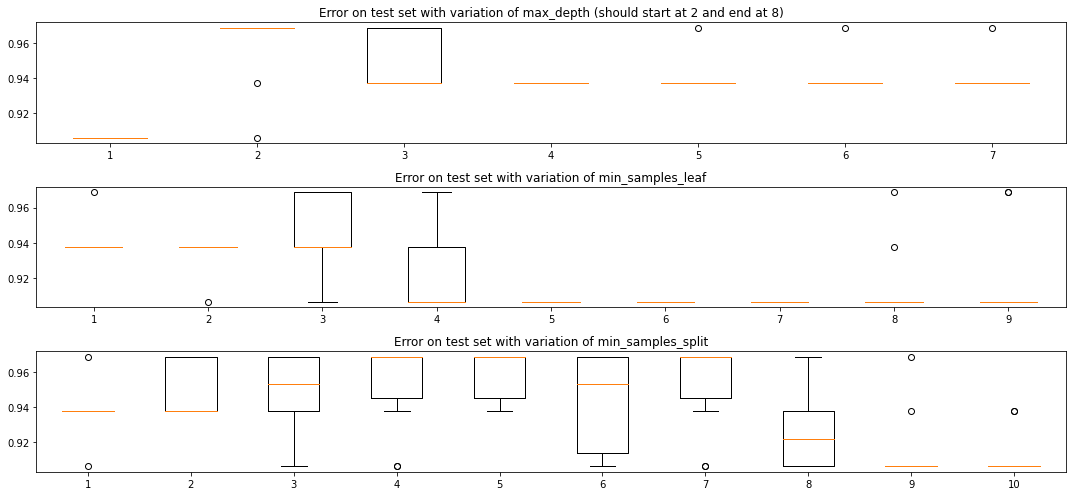

In [84]:
plt.subplot(3,1,1)
plt.boxplot(error_depth)
plt.title("Error on test set with variation of max_depth (should start at 2 and end at 8)")

plt.subplot(3,1,2)
plt.boxplot(error_leaf)
plt.title("Error on test set with variation of min_samples_leaf")

plt.subplot(3,1,3)
plt.boxplot(error_split)
plt.title("Error on test set with variation of min_samples_split")

plt.tight_layout()
plt.show()

*N.B: Had we set random_state to a fixed value, there wouldn't have been any deviation as we would have gotten the same error values everyt time.*

    4 . Let's see how the prediction error of a random forest is estimated.

Previously, we used the score function of scikit-learn to get the test set error of the random forest.

In [87]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
rf = RandomForestClassifier(n_jobs=2, random_state=0)  # n_jobs : number of jobs to run at the same time
rf.fit(train[features], y_train)
error_rf = 1 - rf.score(test[features], y_test)

In [88]:
preds = rf.predict(test[features])
error_rf_cal = np.count_nonzero(preds - y_test) / N_test

In [89]:
print("The error computed with scikit-learn score is " , error_rf)
print("The error computed by ourselves is " , error_rf_cal)

The error computed with scikit-learn score is  0.0625
The error computed by ourselves is  0.0625


The score function on random forest (we used on the test set) computes the percentages of mispredictes values.

But random forest can indeed compute an error directly on the train dataset. Here is why.

Random forest trains each tree on a dataset bootstrapped on the training dataset.

- Bootstrapping a train dataset (with replacement) : this methods creates a new dataset of same size by randomly picking values in the original dataset, given that values already picked can be picked again.

Note: Sometimes the original train dataset has an unbalance share of elements in each class. In this case we can balance back the elements on each class by chosing to pick a value in a class with a well chosen probability.

- After that each tree is created on a subset of the boostrapped data and on a subset of the overall features of the original training set.

- Finally, because of the bootstrapping, for each (or some) values of the original train dataset, we have one or more trees that haven't been trained on this very value. This or these trees creates an out-of-bag sample.

- Therefore we can compute the out-of-bag error by averaging the errors of each value of the original train set, predicted on it srespective out-of-bag sample (the tree classifiers that weren't trained on this specific data).

We can compute the prediction error of random forest directly on the whole dataset whitout having to split it and save a test dataset! This is good, the dataset used for fitting is bigger then.

Let's compute this out-of-bags error.

In [90]:
# training rf on the whole dataset and computing oob_error
rf_oob = RandomForestClassifier(n_jobs=2, random_state=0, oob_score = True)

y_df = pd.factorize(df['species'])[0] # creating the target set of the whole dataset
rf_oob.fit(df[df.columns[:4]], y_df)  # fitting rf on the features of the whole datatset  

C:\Users\Mohammad\anaconda3\envs\AMAL\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForestClassifier(n_jobs=2, oob_score=True, random_state=0)

In [91]:
rf_oob.oob_score_

0.9533333333333334

In [92]:
print('The out-of-bags error with training on the whole dataset is : ',1 - rf_oob.oob_score_)
print('The test error with training on the training set is : ',error_rf)

The out-of-bags error with training on the whole dataset is :  0.046666666666666634
The test error with training on the training set is :  0.0625


The two errors are quite similar even though the oob_error is still lower than the error on the test set. We think it is because the oob error is slightly biased by the training set.

*Question: Is the error on training set (the whole set is the training set and there is no test set) accurate because of the bootstrapping step or because of the step of the subsampling of train set for each tree? or because of both?*

In [93]:
rf_fbst = RandomForestClassifier(n_jobs=2, random_state=0, bootstrap = False)
rf_fbst = rf_fbst.fit(train[features],y_train)
error_rf_fbst = 1 - rf_fbst.score(test[features], y_test)

In [94]:
print("The error on test set with bootstrapping is : " , error_rf)
print("The error on test set without bootstrapping is : " , error_rf_fbst)

print("\nThe oob error with bootstrapping is : " , 1 - rf_oob.oob_score_)

The error on test set with bootstrapping is :  0.0625
The error on test set without bootstrapping is :  0.0625

The oob error with bootstrapping is :  0.046666666666666634


The error on the test set without bootstrap is slightly lower than the one with bootstrap.
We are still not quite sure why both a bootstrap and a subsampling are necessary to create each tree of random forest.

    5. Let's use bootstrap to rebalance values in different classes

As said before, we can rebalance the values in the different classes by recretaing a new train set by picking values from a class of the original train set with the same probability (to get exactly the same share of values in each class).

We have to set the parameter of random forest to 'balanced_subsample'. This way each bootstrapped training set sample (created for each tree of the random forest) will have a balanced share of values in each class.

In [95]:
# rf with class_weight = 'balanced_subsample'
rf_cw = RandomForestClassifier(n_jobs=2, random_state=0, class_weight = 'balanced_subsample')
rf_cw = rf_cw.fit(train[features],y_train)
error_cw_fbst = 1 - rf_cw.score(test[features], y_test)

In [96]:
error_cw_fbst

0.0625

Surprisingly we don't get a lower error than without the classes reweighting. It might be because the original train data set is already balanced (as well as the test set).
Indeed we thought the generated training sets (for each tree of rf) will most likely have unbalanced share of values in each class, without forcing a balance on the subsample).

## Step 5: a small example of regression using random forests
Random forest is capable of learning without carefully crafted data transformations. Take the the $f(x) = \sin(x)$ function for example.

Create some fake data and add a little noise.

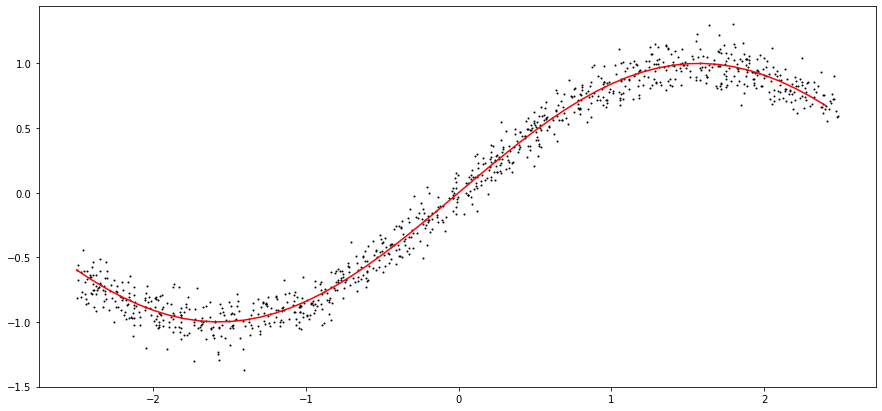

In [97]:
x = np.random.uniform(-2.5, 2.5, 1000)
y = np.sin(x) + np.random.normal(0, .1, 1000)

plt.plot(x,y,'ko',markersize=1,label='data')
plt.plot(np.arange(-2.5,2.5,0.1),np.sin(np.arange(-2.5,2.5,0.1)),'r-',label='ref')
plt.show()

If we try and build a basic linear model to predict y using x we end up with a straight line that sort of bisects the sin(x) function. Whereas if we use a random forest, it does a much better job of approximating the sin(x) curve and we get something that looks much more like the true function.

Based on this example, we will illustrate how the random forest isn't bound by linear constraints.

## Exercise 4
1. Apply random forests on this dataset for regression and compare performances with ordinary least squares regression.
*Note that ordinay least square regression is available thanks to:
from sklearn.linear_model import LinearRegression*

2. Comment on your results.

### Indications:
You may use half of points for training and others to test predictions. Then you will have an idea of how far the random forest predictor fits the sinus curve.

To this aim, you will need to use the model `RandomForestRegressor`. Be careful that when only 1 feature `x` is used as an input, you will need to reshape it by `x.reshape(-1,1)` when using methods `fit` and `predict`.

In [98]:
regrf = RandomForestRegressor(n_estimators=30, max_depth=4)
regrf.fit(x[0::2].reshape(-1, 1),y[0::2])

RandomForestRegressor(max_depth=4, n_estimators=30)

In [99]:
# creating the sinus data set with two features (x_coordinate, y_coordinate)
sin_data = np.vstack((x,y)).T

In [100]:
N_sin = shape(sin_data)[0]

In [101]:
# shuffling randomly the initial dataset
np.random.shuffle(sin_data)

Let's split the sinus dataset into a train and test set of the same size.

In [102]:
sin_train = sin_data[:N_sin//2]
sin_test = sin_data[N_sin//2:]

Let us predict the y_coordinates with random forest regression.

In [103]:
rfr = RandomForestRegressor(n_jobs = 2, random_state = 0)
rfr = rfr.fit(sin_train[:,0].reshape(-1,1), sin_train[:,1])
rfr_predicted = rfr.predict(sin_test[:,0].reshape(-1,1))

Let us predict the y_coordinates with the least square regression method.

Let's first normalize the data.

*Note : we don't have to normalize the data for random forest because the features aren't compared to each other while splitting the nodes.*

In [106]:
sin_data_scaled = preprocessing.scale(sin_data)

reg = LinearRegression(n_jobs = 2)
reg = reg.fit(sin_train[:,0].reshape(-1,1),sin_train[:,1])
reg_predicted = reg.predict(sin_test[:,1].reshape(-1,1))

Let's compute the least square error on both regressions.

In [107]:
def regression_error(x, y):
  
  error = 0
  l = len(x)
  
  for i in range(l):
      error += abs(np.sin(x[i]) - y[i]) ** 2
      
  return error / l

In [108]:
error_rfr = regression_error(sin_test[:,0], rfr_predicted)
error_lr = regression_error(sin_test[:,0], reg_predicted)

In [109]:
print("The regression error with random forest is : " , error_rfr)
print("The regression error with linear regression : " , error_lr)

The regression error with random forest is :  0.004955314586407352
The regression error with linear regression :  0.14905777712641158


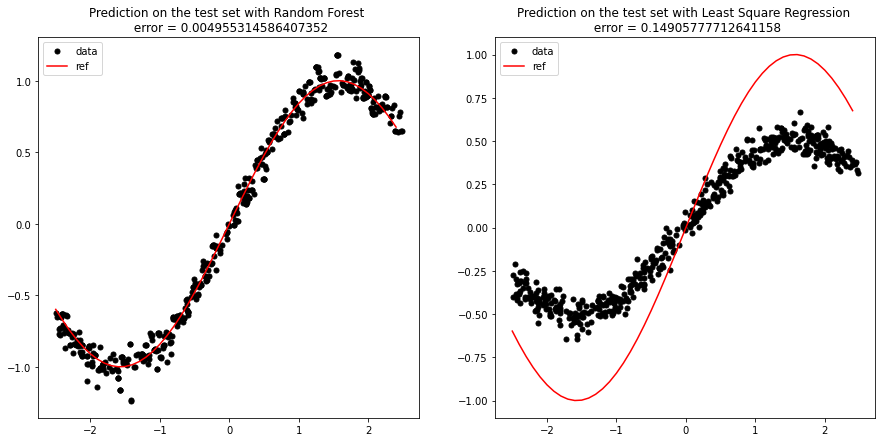

In [110]:
plt.subplot(1,2,1)
plt.plot(sin_test[:,0],rfr_predicted,'ko',markersize=5,label='data')
plt.plot(np.arange(-2.5,2.5,0.1),np.sin(np.arange(-2.5,2.5,0.1)),'r-',label='ref')
plt.title('Prediction on the test set with Random Forest \n error = ' + str(error_rfr))
plt.legend()
          
plt.subplot(1,2,2)
plt.plot(sin_test[:,0],reg_predicted,'ko',markersize=5,label='data')
plt.plot(np.arange(-2.5,2.5,0.1),np.sin(np.arange(-2.5,2.5,0.1)),'r-',label='ref')
plt.title('Prediction on the test set with Least Square Regression \n error = ' + str(error_lr))
plt.legend()
plt.show()

Here we get better prediction with random forest than with Least Square Regression. Indeed random forest can overfit a lot on the training set (this a good thing here because we know our training dataset is accurate). On the other hand, linear regression generalizes too much for our problem.

### Indication
One clever way to compare models when using `scikit-learn`is to make a loop on models as follows:

In [ ]:
models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators)]

for model in models:
    ...
    


## Documentation

### Decision trees
http://scikit-learn.org/stable/modules/tree.html

### Random forests
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### Plot decision surface : using `plt.contourf`
http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html#sphx-glr-auto-examples-tree-plot-iris-py


## Pruning trees: not available in scikit-learn.
Since post-pruning of tree is not implemented in scikit-learn, you may think of coding your own pruning function. For instance, taking into account the numer of samples per leaf as proposed below:

In [ ]:
# Pruning function (useful ?)
def prune(decisiontree, min_samples_leaf = 1):
    if decisiontree.min_samples_leaf >= min_samples_leaf:
        raise Exception('Tree already more pruned')
    else:
        decisiontree.min_samples_leaf = min_samples_leaf
        tree = decisiontree.tree_
        for i in range(tree.node_count):
            n_samples = tree.n_node_samples[i]
            if n_samples <= min_samples_leaf:
                tree.children_left[i]=-1
                tree.children_right[i]=-1
                